In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
# 데이터 경로 설정
dataset_path = "../_preprocessed_datasets_del_aug_duplicate"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish", 
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]

# 이미지 크기 및 하이퍼파라미티 조정
img_height, img_width = 224, 224
batch_size = 32
epochs = 40
learning_rate = 0.001

In [4]:
# 데이터 준비 함수
def prepare_data(dataset_path, categories):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            for file in os.listdir(category_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    filepaths.append(os.path.join(category_path, file))
                    labels.append(category)
    return filepaths, labels

filepaths, labels = prepare_data(dataset_path, categories)

In [5]:
# DataFrame 생성
data = pd.DataFrame({'filename': filepaths, 'class': labels})

In [6]:
# Train/Test 분리
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)

# Train/Validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

In [7]:
# ImageDataGenerator 사용
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 960 validated image filenames belonging to 6 classes.
Found 240 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


In [8]:
# ResNet50 모델 생성
num_classes = len(categories)
model = ResNet50(weights=None, include_top=True, input_shape=(img_height, img_width, 3), classes=num_classes)

In [9]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# 모델 훈련
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/40
30/30 [==============================] - 69s 441ms/step - loss: 2.3654 - accuracy: 0.2979 - val_loss: 1.8165 - val_accuracy: 0.2625
Epoch 2/40
30/30 [==============================] - 12s 400ms/step - loss: 1.7061 - accuracy: 0.3854 - val_loss: 2.0670 - val_accuracy: 0.1750
Epoch 3/40
30/30 [==============================] - 12s 394ms/step - loss: 1.4655 - accuracy: 0.4208 - val_loss: 2.2436 - val_accuracy: 0.2583
Epoch 4/40
30/30 [==============================] - 12s 393ms/step - loss: 1.3466 - accuracy: 0.4958 - val_loss: 2.0764 - val_accuracy: 0.2875
Epoch 5/40
30/30 [==============================] - 12s 401ms/step - loss: 1.2798 - accuracy: 0.5177 - val_loss: 2.7372 - val_accuracy: 0.1833
Epoch 6/40
30/30 [==============================] - 12s 396ms/step - loss: 1.2789 - accuracy: 0.5292 - val_loss: 2.9351 - val_accuracy: 0.1917
Epoch 7/40
30/30 [==============================] - 12s 396ms/step - loss: 1.2434 - accuracy: 0.5552 - val_loss: 1.9778 - val_accuracy: 0.3250

In [11]:
# 테스트 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

10/10 [==============================] - 2s 155ms/step - loss: 0.7176 - accuracy: 0.7667
Test Loss: 0.7176, Test Accuracy: 0.7667


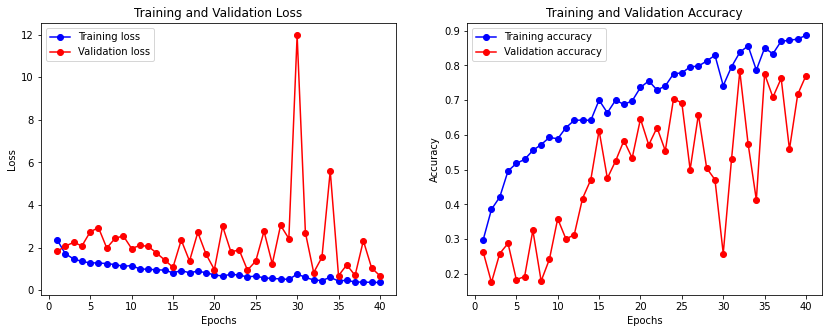

In [12]:
# 훈련 이력 시각화
def plot_training_history(history):
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], 'bo-', label='Training accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

## ResNet50 모델
---

성능이 점점 좋아지다가 30번째 에포크에서 나락을감.  
32번째 에포크에서 가장 성능이 좋았음 최대 78%의 정확도.